In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import os
import sys
import json
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors as colors
import ipdb
import platform
opj = os.path.join
deb = ipdb.set_trace
%matplotlib inline
import time

# MRI imports
# -----------
import nibabel as nb
import cortex

subject = '999999'

# Define analysis parameters
# --------------------------
with open('../../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Define cluster/server specific parameters
# -----------------------------------------
if 'aeneas' in platform.uname()[1]:
    base_dir = analysis_info['aeneas_base_folder']
elif 'local' in platform.uname()[1]:
    base_dir = analysis_info['local_base_folder']

fit_model = 'gauss'
deriv_dir = opj(base_dir,'pp_data',subject,fit_model,'deriv')

# Create derivatives flatmaps
# ---------------------------
sign_idx, rsq_idx, ecc_idx, polar_real_idx, polar_imag_idx , size_idx, \
            non_lin_idx, amp_idx, baseline_idx, cov_idx, x_idx, y_idx = 0,1,2,3,4,5,6,7,8,9,10,11
mask_dir  = 'all'

# Get data and combine hemispheres
deriv_mat=[]
for hemi in ['L','R']:
    deriv_file = nb.load(opj(deriv_dir,mask_dir,"prf_deriv_{hemi}_{mask_dir}_fsaverage.func.gii".format(hemi = hemi, mask_dir = mask_dir)))
    deriv_mat.append(np.array([deriv_file.darrays[i].data for i in range(len(deriv_file.darrays))]))
deriv_mat = np.hstack(deriv_mat)
deriv_mat = deriv_mat.T

In [41]:
# R-square
rsq_data = deriv_mat[:,rsq_idx]
rsq_data = rsq_data*255.0
rsq_data = rsq_data.astype(np.uint8)

data4mask = deriv_mat
rsq_data[np.logical_or(np.logical_or(  data4mask[:,rsq_idx]<=0.0,
                                        data4mask[:,cov_idx]<=0.0),
                                        data4mask[:,size_idx]<=0)] = 0.0

cmap_steps = 255

sign_data = deriv_mat[:,sign_idx]
norm_sign_data = (sign_data - np.nanmin(sign_data))/(np.nanmax(sign_data)-np.nanmin(sign_data))
norm_sign_data_digit = np.digitize(norm_sign_data,np.linspace(0,1,cmap_steps,endpoint=False))
norm_sign_data_discrete = norm_sign_data_digit/cmap_steps - (1/(cmap_steps*2))
norm_sign_data_discrete = norm_sign_data_discrete*256.0
norm_sign_data_discrete = norm_sign_data_discrete.astype(np.uint8)

In [42]:
vertex_2d = cortex.Vertex2D(  dim1 = norm_sign_data_discrete, 
                              dim2 = rsq_data,
                              description = 'sign',
                              subject = 'fsaverage', 
                              cmap = 'RdBu_r_alpha', 
                              vmin = 0,
                              vmax = 255,
                              vmin2 = 0,
                              vmax2 = 255,
                         )


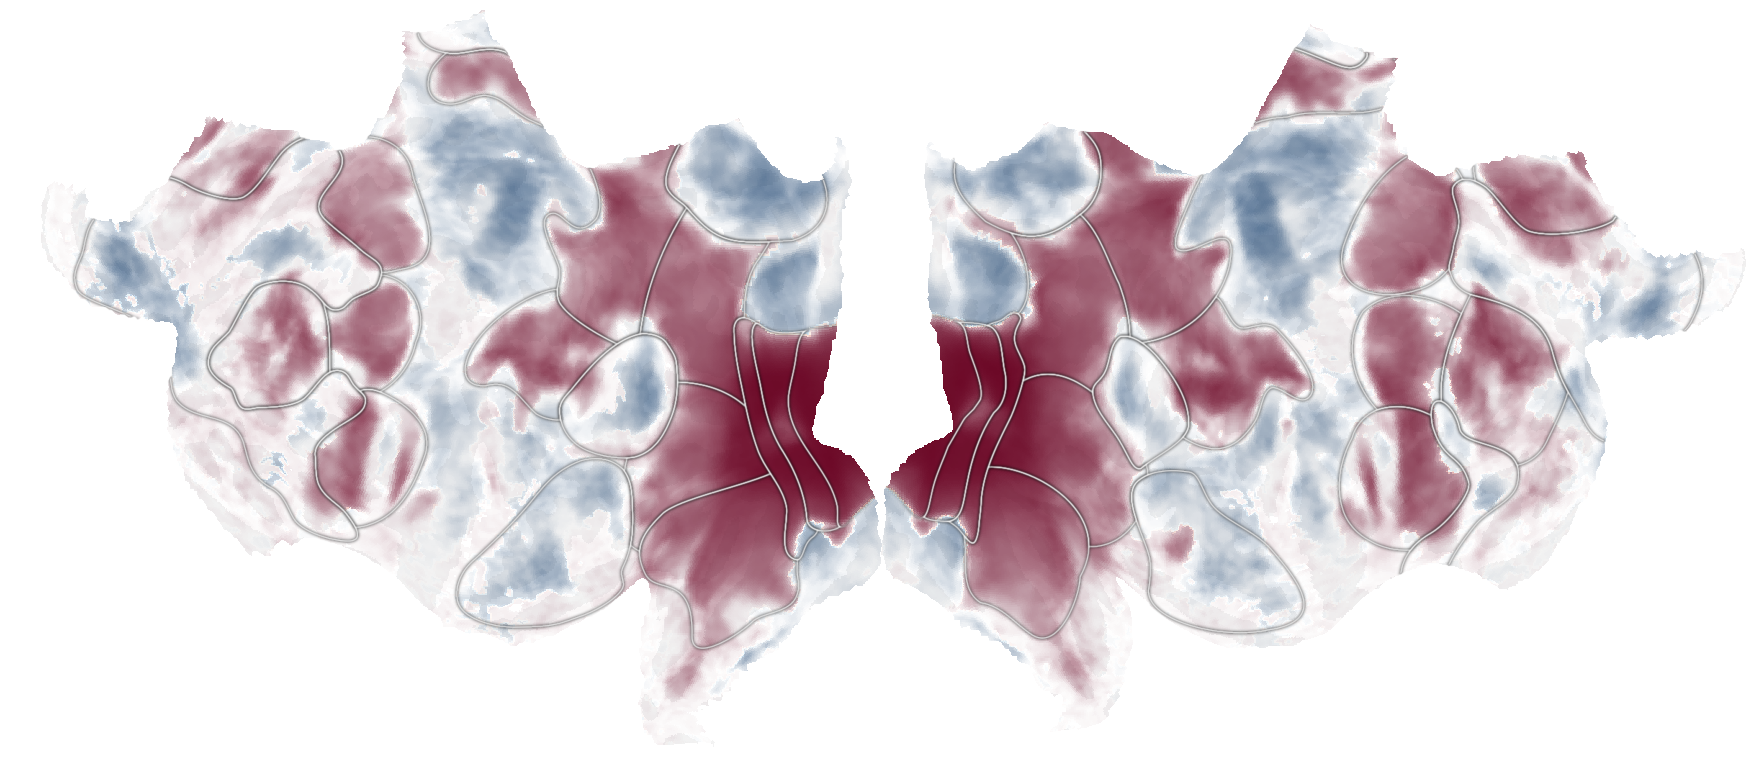

In [48]:
vertex2 = cortex.quickshow( braindata = vertex_2d,
                            with_curvature = True,
                            with_labels = False,
                            with_colorbar = False,
                            curvature_brightness = 1,
                            curvature_contrast = 0.1, 
                            with_borders = False,
                          )
img_dir = '/home/szinte/projects/retino_HCP/post_fit/notebooks/figs/Figure2A/'
try: os.makedirs(img_dir)
except: pass
plt.savefig("{imdir}flat_svg.pdf".format(imdir = img_dir),facecolor="w")